In [1]:
# To ignore deprecated warnings
import os
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
import os
import random
import numpy as np
from gensim.models import word2vec #  word2vec 관련 모델을 제공해주는 library  
import nltk
from nltk.corpus import movie_reviews # corpus 를 가져오는 용도 
from sklearn.manifold import TSNE # 시각화를 위한 TSNE 사용 
from sklearn.metrics import accuracy_score # accuracy score 를 계산하기 위한 metric 라이브러리 불러오기 
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from torch.utils import data # pytorch data class 
import torch.nn as nn # pytorch neural network 불러오기 
import torch.nn.utils.rnn as rnn_utils # rnn utils
import torch

import pickle

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chapter 1

# Word embedding (CBOW & Skip-Gram)

![대체 텍스트](./figures/embedding.png)

![대체 텍스트](./figures/w2vec_1.png)

In [3]:
# 파라메터값 지정
num_features = 300 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 한 문장에 대한 최소 문자 수
window = 5 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 높은 단어에 대해 빈도수를 낮춤
epoch = 5 # epoch 수

In [4]:
# preparing data
data_path = '/content/drive/MyDrive/NLP/실습1'
sentences = []
pos_data = open(os.path.join(data_path, "lm_data/pos/train.txt")).readlines()
neg_data = open(os.path.join(data_path, "lm_data/neg/train.txt")).readlines()
data_ = pos_data + neg_data
for line in data_:
    sentences.append(line.strip().split(' '))

print(len(sentences))

62966


In [5]:
# skip-gram 모델 학습
skip_gram = word2vec.Word2Vec(sentences,
                              sg = 1, # skip-gram
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

# CBOW 모델 학습
CBOW = word2vec.Word2Vec(sentences,
                              sg = 0, # CBOW
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

2022-01-20 04:27:08,385 : INFO : collecting all words and their counts
2022-01-20 04:27:08,386 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-20 04:27:08,438 : INFO : PROGRESS: at sentence #10000, processed 239982 words, keeping 20149 word types
2022-01-20 04:27:08,489 : INFO : PROGRESS: at sentence #20000, processed 475267 words, keeping 28557 word types
2022-01-20 04:27:08,539 : INFO : PROGRESS: at sentence #30000, processed 718530 words, keeping 35153 word types
2022-01-20 04:27:08,586 : INFO : PROGRESS: at sentence #40000, processed 942659 words, keeping 40650 word types
2022-01-20 04:27:08,639 : INFO : PROGRESS: at sentence #50000, processed 1164181 words, keeping 45109 word types
2022-01-20 04:27:08,685 : INFO : PROGRESS: at sentence #60000, processed 1387734 words, keeping 49141 word types
2022-01-20 04:27:08,700 : INFO : collected 50290 word types from a corpus of 1453943 raw words and 62966 sentences
2022-01-20 04:27:08,703 : INFO : Loading 

##  Training result

In [6]:
skip_gram.wv.most_similar("man") # skip-gram 모델을 이용하여 'man'에 가장 유사한 단어 추출

2022-01-20 04:29:37,360 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.7305389046669006),
 ('boy', 0.7302446365356445),
 ('person', 0.7080674171447754),
 ('teenager', 0.6870431303977966),
 ('doctor', 0.6725258827209473),
 ('girl', 0.6679054498672485),
 ('guy', 0.6659172773361206),
 ('lady', 0.6525713205337524),
 ('kid', 0.648500382900238),
 ('murderer', 0.6362298727035522)]

In [7]:
CBOW.wv.most_similar("man") # CBOW 모델을 이용하여 'man'에 가장 유사한 단어 추출

2022-01-20 04:30:16,967 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.9237513542175293),
 ('girl', 0.9055048823356628),
 ('boy', 0.8676897883415222),
 ('child', 0.7916035652160645),
 ('guy', 0.7698088884353638),
 ('person', 0.7677820920944214),
 ('kid', 0.7658615112304688),
 ('doctor', 0.7587997913360596),
 ('cop', 0.7562705278396606),
 ('scientist', 0.750747799873352)]

In [8]:
vector = skip_gram["king"] - skip_gram["man"] + skip_gram["women"]
skip_gram.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)

[('king', 0.6201279759407043),
 ('veterans', 0.5864250063896179),
 ('politicians', 0.5840903520584106),
 ('screenwriters', 0.5622386932373047),
 ('various', 0.5620972514152527),
 ('fighters', 0.5553898215293884),
 ('exotic', 0.5549821853637695),
 ('personalities', 0.5522608160972595),
 ('numerous', 0.5490250587463379),
 ('couples', 0.5485239028930664)]

In [9]:
def render_TSNE(vocab, word_emb):
    """
    TSNE를 이용한 word2vec 시각화 
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) #TSNE 시각화를 위한 initialization
    _tsne = tsne.fit_transform(word_emb) # TSNE 시각화 적용
    x_coordinate = _tsne[:,0] # x 좌표
    y_coordinate = _tsne[:,1] # y 좌표

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # 각 scatter들에대해 단어 labeling

    plt.show()

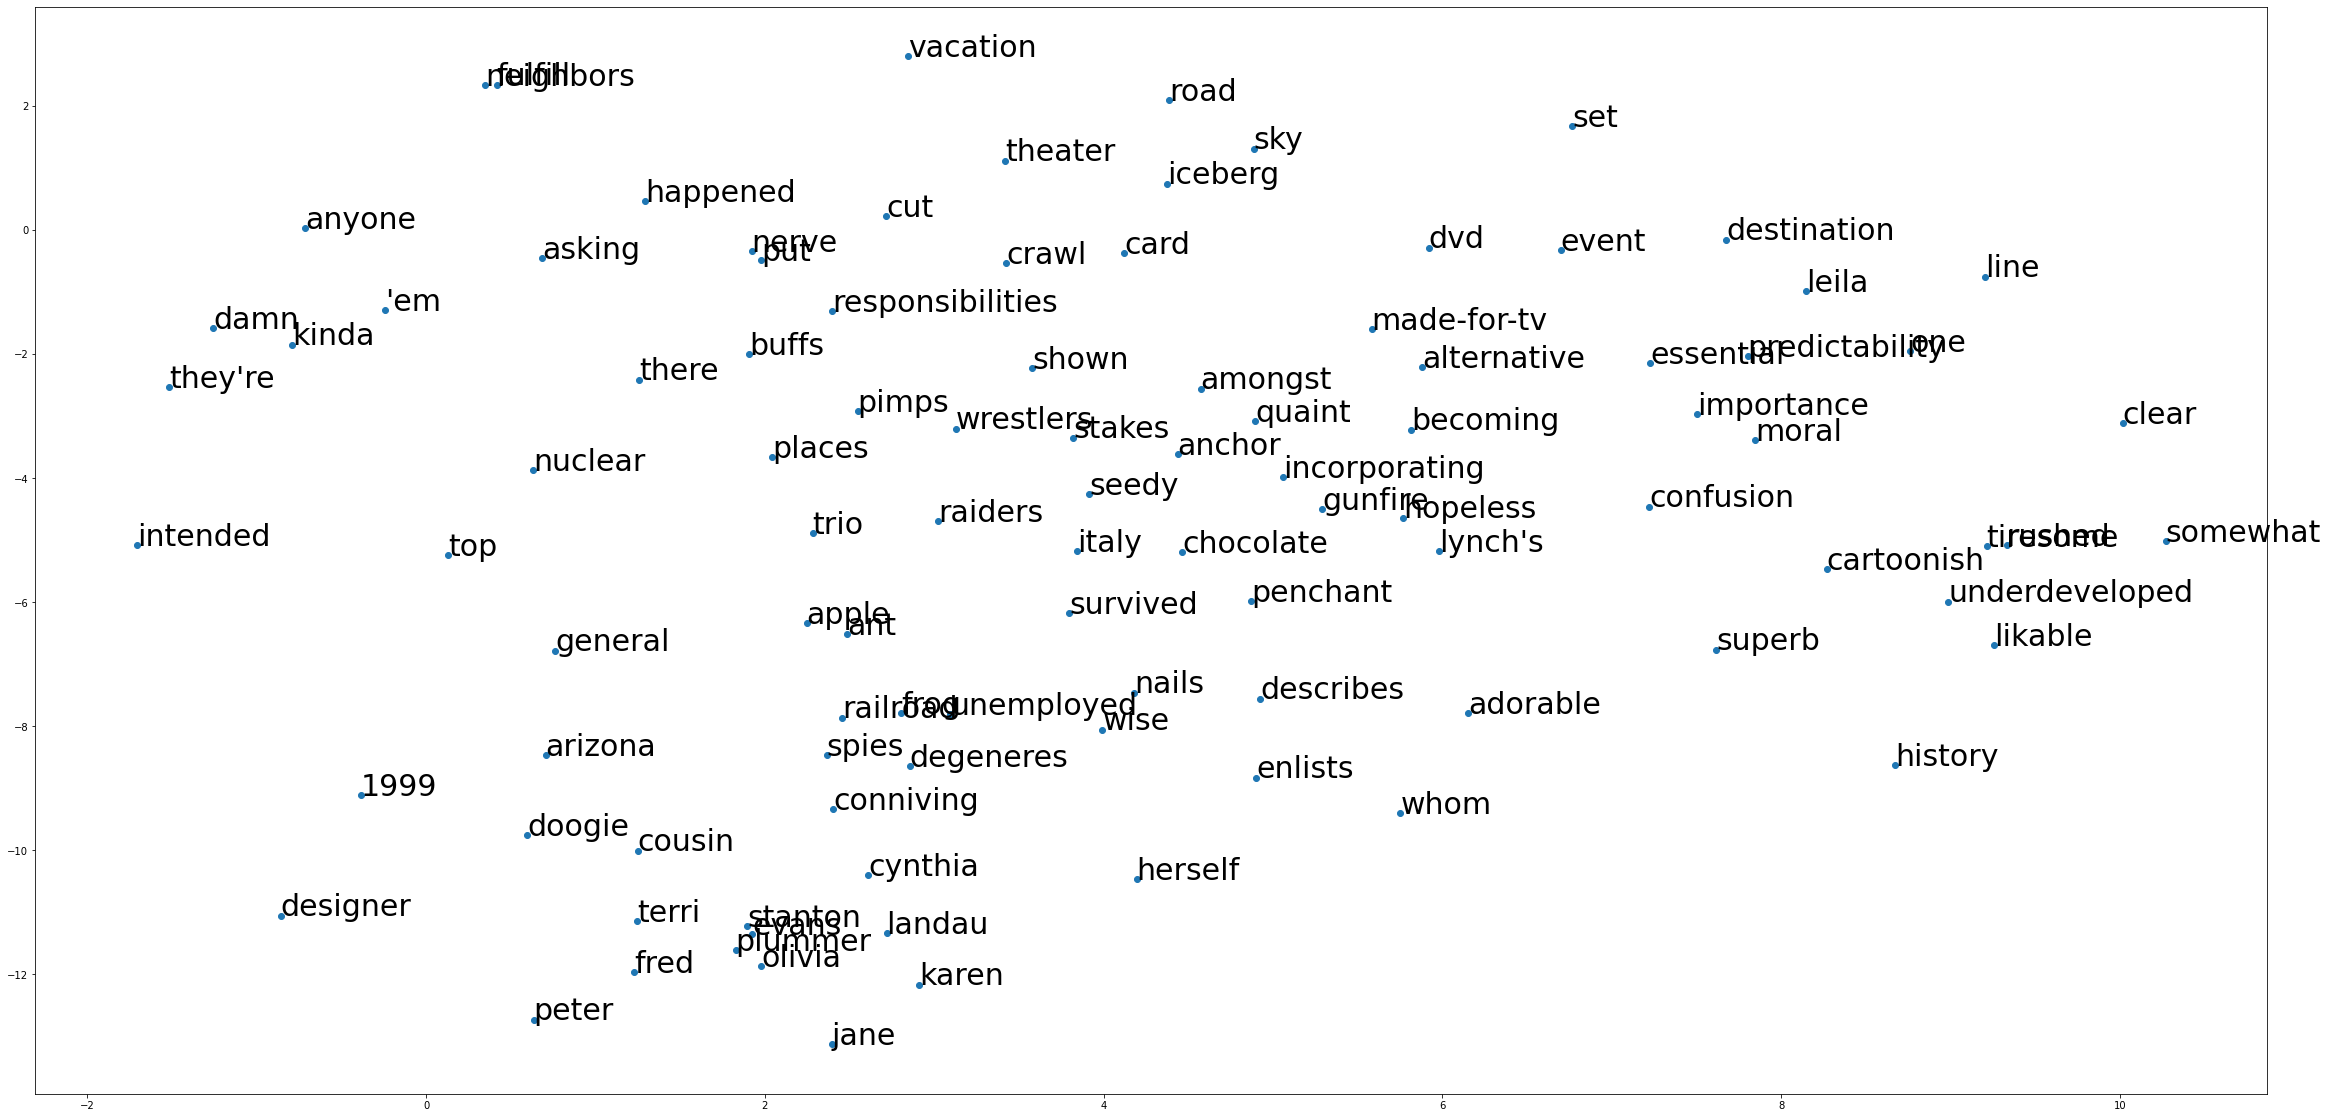

In [10]:
# Skip-gram 시각화(TSNE)
vocab = list(skip_gram.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화

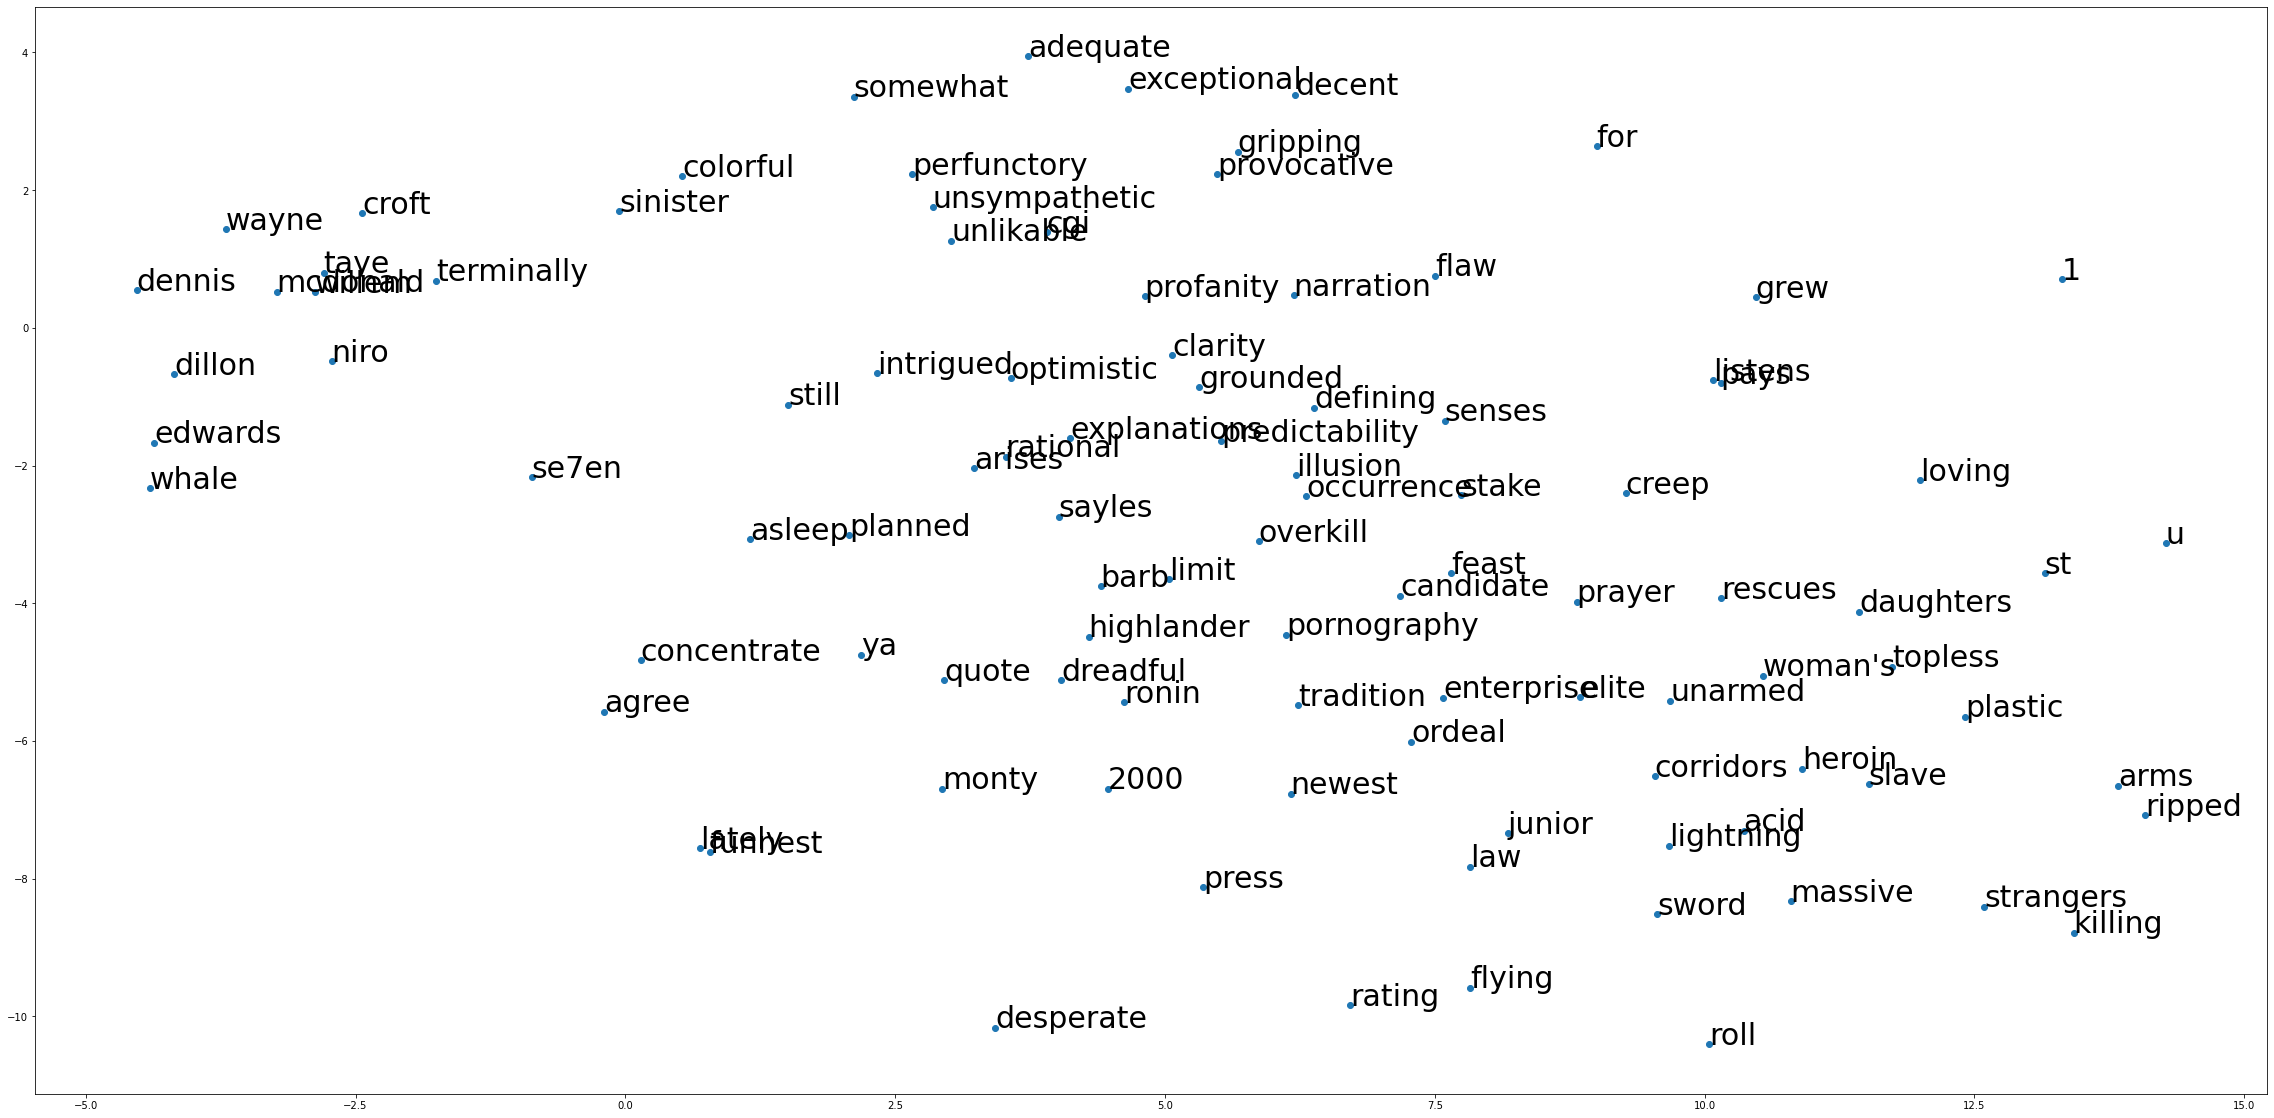

In [11]:
# CBOW 시각화(TSNE)
vocab = list(CBOW.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화

# Chapter2

# Lanaguage Model (RNN)

![대체 텍스트](./figures/lm_1.jpg)

In [13]:
def build_dict(seqs):
    num_skip_sent = 0
    word_count = 4
    vocab = ["<pad>","<s>","</s>","<unk>"]
    word2id = {"<pad>": 0, "<s>": 1, "</s>": 2, "<unk>": 3}
    id2word = {0: "<pad>", 1: "<s>", 2: "</s>", 3: "<unk>"}
    print("Building vocab and dict..")
    for line in seqs:
        words = line.strip().split(' ') # tokenized by space 
        for word in words:
            if word not in vocab:
                word_count += 1 # increment word_count
                vocab.append(word) # append new unique word
                index = word_count - 1 # word index (consider index 0)
                word2id[word] = index # word to index
                id2word[index] = word # index to word
    
    print("Number of unique words: %d" % len(vocab))
    print("Finised building vocab and dict!")

    return vocab, word2id, id2word

In [14]:
# Training corpus를 사용하여 vocab과 dict 구성
assert os.path.isfile(os.path.join(data_path, "lm_data/pos/train.txt"))
assert os.path.isfile(os.path.join(data_path, "lm_data/neg/train.txt"))
pos_seqs = open(os.path.join(data_path, "lm_data/pos/train.txt")).readlines()
neg_seqs = open(os.path.join(data_path, "lm_data/neg/train.txt")).readlines()
seqs = pos_seqs + neg_seqs # 긍정 corpus + 부정 corpus

In [15]:
print(seqs[1])

for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 



In [16]:
# Building vocab or loading existing vocab
path = os.path.join(data_path, "lm_id2word.pkl")
if os.path.isfile(path):
    with open(os.path.join(data_path, "lm_id2word.pkl"), "rb") as f:
        id2word = pickle.load(f)
    with open(os.path.join(data_path, "lm_word2id.pkl"), "rb") as f:
        word2id = pickle.load(f)
    with open(os.path.join(data_path, "lm_vocab.pkl"), "rb") as f:
        vocab = pickle.load(f)

else:
    vocab, word2id, id2word = build_dict(seqs)
    pickle.dump(vocab, open(os.path.join(data_path, "lm_vocab.pkl"), "wb" ))
    pickle.dump(word2id, open(os.path.join(data_path, "lm_word2id.pkl"), "wb" ))
    pickle.dump(id2word, open(os.path.join(data_path, "lm_id2word.pkl"), "wb" ))

In [17]:
# example of first 10 word2id
for index, word in enumerate(word2id.keys()):
    print({word: word2id[word]})
    if index == 9:
        break

{'<pad>': 0}
{'<s>': 1}
{'</s>': 2}
{'<unk>': 3}
{'films': 4}
{'adapted': 5}
{'from': 6}
{'comic': 7}
{'books': 8}
{'have': 9}


In [18]:
# example of first 10 id2word
for index, id in enumerate(id2word.keys()):
    print({id: id2word[id]})
    if index == 9:
        break

{0: '<pad>'}
{1: '<s>'}
{2: '</s>'}
{3: '<unk>'}
{4: 'films'}
{5: 'adapted'}
{6: 'from'}
{7: 'comic'}
{8: 'books'}
{9: 'have'}


In [19]:
class LM_Dataset(data.Dataset):

    def __init__(self, pos_path, neg_path , word2id):
        
        #(add+)
        self.pos_seqs = open(pos_path).readlines()
        self.pos_labels = [0] * len(self.pos_seqs)
        self.neg_seqs = open(neg_path).readlines()
        self.neg_labels = [1] * len(self.neg_seqs)
        self.seqs = self.pos_seqs + self.neg_seqs # concat pos_seqs and neg_seqs
        self.labels = self.pos_labels + self.neg_labels
        
        self.word2id = word2id


    def __getitem__(self, index): # 가장 중요한 part Dataset 을 상속한 클래스는 이 부분을 overriding 해줘야함. 
        """Returns one data pair (source and sentiment)."""
        seqs = self.seqs[index]
        seqs = self.process(seqs, self.word2id)
        sentiment_labels = self.labels[index]
        return seqs, sentiment_labels

    def __len__(self): # 필수적인 클래스 이 부분을 무조건 overriding 해야함 
        return len(self.seqs) # 데이터 갯수 return 
                    
    def process(self, seq, word2id):
        sequence = []
        sequence.append(word2id["<s>"])
        words = seq.strip().split(' ')
        if len(words) <= 250: # max seq_len = 100
            for word in words:
                if word in word2id:
                    sequence.append(word2id[word]) # 
                else:
                    sequence.append(3) # replace by <unk> token
        sequence.append(word2id["</s>"])
        sequence = torch.Tensor(sequence)
        return sequence

### Batch 를 구성해보겠습니다. 
Q : 우리의 문장에서 항상 단어의 갯수는 일정한가요?

문제점: Tensor로 변환하기 위해서는 추가 처리 필요 . eg. Sentence1 : W1 , W2, W3 ,W4 / Sentence : W1 , W2 ,W3 ->  2*3이 맞나요? 2*4가 맞나요? 

해결법 : Batch * max_length  Tensor로 변환합니다. eg. 2*4의 경우 2 번째 문장의 마지막에 PAD_token을 처리해줍니다. Index 보통 : 0 

In [20]:
def batch(iterable, n=1):
    args = [iter(iterable)] * n
    return zip_longest(*args)


def pad_tensor(vec, pad, value=0, dim=0):
    """
    pad token으로 채우는 용도 
    args:
        vec - tensor to pad
        pad - the size to pad to
        dim - dimension to pad
    return:
        a new tensor padded to 'pad' in dimension 'dim'
    """
    pad_size = pad - vec.shape[0]

    if len(vec.shape) == 2:
        zeros = torch.ones((pad_size, vec.shape[-1])) * value
    elif len(vec.shape) == 1:
        zeros = torch.ones((pad_size,)) * value
    else:
        raise NotImplementedError
    return torch.cat([torch.Tensor(vec), zeros], dim=dim)

![대체 텍스트](./figures/sorted.jpg)

In [29]:
def collate_fn(batch, values=(0, 0), dim=0):
    """
    데이터 로더에 들어가기전에 batch화 할 때 거치는 함수 
    args:
        batch - list of (tensor, label)
    reutrn:
        xs - a tensor of all examples in 'batch' after padding
        ys - a LongTensor of all labels in batch
        ws - a tensor of sequence lengths
    """

    sequence_lengths = torch.Tensor([int(x[0].shape[dim]) for x in batch]) # 각 batch 마다 길이를 얻어내고 
    sequence_lengths, xids = sequence_lengths.sort(descending=True) # 감소하는 순서로 정렬
    # find longest sequence (가장 긴 sequence의 길이를 구함 )
    max_len = max(map(lambda x: x[0].shape[dim], batch))
    # pad according to max_len (max length 만큼 padd를 추가 )
    batch = [(pad_tensor(x, pad=max_len, dim=dim), label) for (x, label) in batch]

    # stack all
    xs = torch.stack([x[0] for x in batch], dim=0)
    xs = xs[xids].contiguous() # decreasing order로 다시 나열
    
    labels = [x[1] for x in batch]
    labels = [labels[i] for i in xids] # decreasing order로 다시 나열
    
    return xs.long(), sequence_lengths.int(), torch.Tensor(labels)

### Build Language model

### Example  pack padded

In [30]:
a = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b = torch.nn.utils.rnn.pad_sequence(a, batch_first=True)
b

tensor([[1, 2, 3],
        [3, 4, 0]])

In [31]:
pack_b=torch.nn.utils.rnn.pack_padded_sequence(b, batch_first=True, lengths=[3,2])
pack_b

PackedSequence(data=tensor([1, 3, 2, 4, 3]), batch_sizes=tensor([2, 2, 1]), sorted_indices=None, unsorted_indices=None)

In [32]:
rnn_utils.pad_packed_sequence(pack_b,batch_first=True,padding_value=0.)

(tensor([[1, 2, 3],
         [3, 4, 0]]), tensor([3, 2]))

## Model

In [54]:
class LM(nn.Module):
    def __init__(self, config, vocab_size):
        super(LM, self).__init__()
        self.vocab_size = vocab_size # get vocabulary size 
        self.embedding = nn.Embedding(self.vocab_size, config["embedding_size"])  # initialize embedding layer 
        self.rnn = nn.RNN(input_size=config["embedding_size"], hidden_size=config["hidden_size"], num_layers=config['decoder_layers'],
                          dropout=config["dropout"], batch_first=True) # defined rnn layer 
        self.outputs2vocab = nn.Linear(config["hidden_size"], self.vocab_size) # linear layer to predict the sentiment
    def forward(self,input, lengths):
        # ---------------- fill in ------------------------ 
        batch_size = input.size(0) # get batch_size
        input_embedding = self.embedding(input) # embedding layer  (B,L) -> (B,L ,hidden)
        packed_input = rnn_utils.pack_padded_sequence(input_embedding, lengths, batch_first=True) # pack sequence 
        outputs, _ = self.rnn(packed_input) # rnn 
        padded_outputs = rnn_utils.pad_packed_sequence(outputs, batch_first=True, padding_value=0.)[0] # packed sequence 
        padded_outputs = padded_outputs.contiguous()
        outputs = self.outputs2vocab(padded_outputs)
        logits = outputs.contiguous().view(-1, self.vocab_size)
        # ---------------- fill in ------------------------ 
        return logits

In [57]:
config = {
  "epochs": 1,
  "hidden_size": 64,
  "decoder_layers": 3,
  "dropout": 0.2,
  "batch_size": 32,
  "embedding_size": 64,
  "learning_rate": 0.001,
}

In [58]:
train_dataset = LM_Dataset(os.path.join(data_path, "lm_data/pos/train.txt"), os.path.join(data_path, "lm_data/neg/train.txt"), word2id)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=True,
                                          collate_fn=collate_fn)

valid_dataset = LM_Dataset(os.path.join(data_path, "lm_data/pos/valid.txt"), os.path.join(data_path, "lm_data/neg/valid.txt"), word2id)
valid_data_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          collate_fn=collate_fn)
test_dataset = LM_Dataset(os.path.join(data_path, "lm_data/pos/test.txt"), os.path.join(data_path, "lm_data/neg/test.txt"), word2id)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          collate_fn=collate_fn)

In [59]:
def lm_train(model, optimizer, train_loader, epoch,n_epochs):
    
    losses = []

    model.train() # train mode
    n_iter = 0
    for batch in train_loader:
        input, input_lengths, _ = batch 
        output = model(input[:,:-1].contiguous().to(device),(input_lengths-1))
        loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)
        target = input[:,1:].contiguous().view(-1) 
        loss = loss_fn(output,target.to(device))
        losses.append(loss.item())
        # ------------------ fill in -------------------
        # Reset gradients
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # step optimizer 
        optimizer.step()
        # ------------------ fill in -------------------
        n_iter+=1 # count number of trained sentences
        if n_iter % 100 == 0: # print loss info for every 100 iteration steps
            print ('\n [{}] current_iter_loss= {:05.3f}'.format(n_iter,loss))
  
    print ('\n Epoch({}/{}) avg_loss= {:05.3f}'.format(epoch+1,n_epochs,np.mean(losses)))
    
    return model, optimizer

In [60]:
def lm_eval(model, loader):
    losses = []

    model.eval() # valid mode
    n_iter = 0
 
    for batch in loader:
        input, input_lengths, _ = batch
        output = model(input[:,:-1].contiguous().to(device),(input_lengths-1))
        loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)
        target = input[:,1:].contiguous().view(-1)
        loss = loss_fn(output,target.to(device))
        losses.append(loss.item())
    
    return losses

In [61]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LM(config, vocab_size=len(vocab))
optimizer = torch.optim.Adam(model.parameters(), lr=config.get("learning_rate", .001))

# Train model
for epoch in range(config["epochs"]):
    model,optimizer  = lm_train(model.to(device),optimizer, train_data_loader, epoch,config["epochs"]) # train
    valid_loss = lm_eval(model.to(device), valid_data_loader) # valid
    print ('\n              avg_valid loss= {:05.3f}'.format(np.mean(valid_loss)))
    test_loss = lm_eval(model.to(device), test_data_loader) # test
    print ('\n              avg_test loss= {:05.3f}'.format(np.mean(test_loss)))


 [100] current_iter_loss= 6.986

 [200] current_iter_loss= 6.972

 [300] current_iter_loss= 6.791

 [400] current_iter_loss= 6.771

 [500] current_iter_loss= 6.458

 [600] current_iter_loss= 6.483

 [700] current_iter_loss= 6.430

 [800] current_iter_loss= 6.371

 [900] current_iter_loss= 6.140

 [1000] current_iter_loss= 6.301

 [1100] current_iter_loss= 6.398

 [1200] current_iter_loss= 6.360

 [1300] current_iter_loss= 6.368

 [1400] current_iter_loss= 6.285

 [1500] current_iter_loss= 6.187

 [1600] current_iter_loss= 5.944

 [1700] current_iter_loss= 6.257

 [1800] current_iter_loss= 5.946

 [1900] current_iter_loss= 6.110

 Epoch(1/1) avg_loss= 6.503

              avg_valid loss= 5.973

              avg_test loss= 5.869


### Layer 를 더 깊게 

In [62]:
config = {
  "epochs": 1,
  "hidden_size": 64,
  "decoder_layers": 3,
  "dropout": 0.2,
  "batch_size": 32,
  "embedding_size": 64,
  "learning_rate": 0.001,
}

In [63]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LM(config, vocab_size=len(vocab))
optimizer = torch.optim.Adam(model.parameters(), lr=config.get("learning_rate", .001))

# Train model
for epoch in range(config["epochs"]):
    model,optimizer  = lm_train(model.to(device),optimizer, train_data_loader, epoch,config["epochs"]) # train
    valid_loss = lm_eval(model.to(device), valid_data_loader) # valid
    print ('\n              avg_valid loss= {:05.3f}'.format(np.mean(valid_loss)))
    test_loss = lm_eval(model.to(device), test_data_loader) # test
    print ('\n              avg_test loss= {:05.3f}'.format(np.mean(test_loss)))


 [100] current_iter_loss= 7.296

 [200] current_iter_loss= 6.949

 [300] current_iter_loss= 6.750

 [400] current_iter_loss= 6.671

 [500] current_iter_loss= 6.827

 [600] current_iter_loss= 6.527

 [700] current_iter_loss= 6.188

 [800] current_iter_loss= 6.473

 [900] current_iter_loss= 6.345

 [1000] current_iter_loss= 6.332

 [1100] current_iter_loss= 6.088

 [1200] current_iter_loss= 6.138

 [1300] current_iter_loss= 6.165

 [1400] current_iter_loss= 6.220

 [1500] current_iter_loss= 6.167

 [1600] current_iter_loss= 6.094

 [1700] current_iter_loss= 6.086

 [1800] current_iter_loss= 5.841

 [1900] current_iter_loss= 6.214

 Epoch(1/1) avg_loss= 6.455

              avg_valid loss= 5.939

              avg_test loss= 5.808


### GRU로 변경하기 

In [68]:
class LM(nn.Module):
    def __init__(self, config, vocab_size):
        super(LM, self).__init__()
        self.vocab_size = vocab_size # get vocabulary size 
        self.embedding = nn.Embedding(self.vocab_size, config["embedding_size"])  # initialize embedding layer 
        # ------------------------- fill in --------------------------------
        self.rnn = nn.GRU(input_size=config["embedding_size"], hidden_size=config["hidden_size"], num_layers=config['decoder_layers'],
                          dropout=config["dropout"], batch_first=True)
        self.outputs2vocab = nn.Linear(config["hidden_size"], self.vocab_size)   # linear layer to predict the sentiment
        # ------------------------- fill in --------------------------------
    def forward(self,input, lengths):
        batch_size = input.size(0) # get batch_size
        input_embedding = self.embedding(input) # embedding layer  (B,L) -> (B,L ,hidden)
        packed_input = rnn_utils.pack_padded_sequence(input_embedding, lengths, batch_first=True) # pack sequence 
        outputs, _ = self.rnn(packed_input)   # rnn 
        padded_outputs = rnn_utils.pad_packed_sequence(outputs, batch_first=True, padding_value=0.)[0] # packed sequence 
        padded_outputs = padded_outputs.contiguous()
        outputs = self.outputs2vocab(padded_outputs) 
        logits = outputs.contiguous().view(-1, self.vocab_size)
        return logits

In [69]:
config = {
  "epochs": 1,
  "hidden_size": 64,
  "decoder_layers": 3,
  "dropout": 0.2,
  "batch_size": 32,
  "embedding_size": 64,
  "learning_rate": 0.001,
}

In [70]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LM(config, vocab_size=len(vocab))
optimizer = torch.optim.Adam(model.parameters(), lr=config.get("learning_rate", .001))

# Train model
for epoch in range(config["epochs"]):
    model,optimizer  = lm_train(model.to(device),optimizer, train_data_loader, epoch,config["epochs"]) # train
    valid_loss = lm_eval(model.to(device), valid_data_loader) # valid
    print ('\n              avg_valid loss= {:05.3f}'.format(np.mean(valid_loss)))
    test_loss = lm_eval(model.to(device), test_data_loader) # test
    print ('\n              avg_test loss= {:05.3f}'.format(np.mean(test_loss)))


 [100] current_iter_loss= 6.833

 [200] current_iter_loss= 7.204

 [300] current_iter_loss= 6.677

 [400] current_iter_loss= 6.733

 [500] current_iter_loss= 6.929

 [600] current_iter_loss= 6.552

 [700] current_iter_loss= 6.537

 [800] current_iter_loss= 6.922

 [900] current_iter_loss= 6.475

 [1000] current_iter_loss= 6.771

 [1100] current_iter_loss= 6.569

 [1200] current_iter_loss= 6.529

 [1300] current_iter_loss= 6.285

 [1400] current_iter_loss= 6.325

 [1500] current_iter_loss= 6.558

 [1600] current_iter_loss= 6.647

 [1700] current_iter_loss= 6.100

 [1800] current_iter_loss= 6.074

 [1900] current_iter_loss= 6.081

 Epoch(1/1) avg_loss= 6.661

              avg_valid loss= 6.075

              avg_test loss= 5.980


# Chatper 3 

# Sentiment Classfication

In [74]:
class Sentiment_Dataset(data.Dataset):

    def __init__(self, path , word2id):
        self.seqs = open(path).readlines()
        self.word2id = word2id

    def __getitem__(self, index):
        """Returns one data pair (source and sentiment)."""
        seqs = self.seqs[index]
        seqs, label = self.process(seqs, self.word2id)
        return seqs, label

    def __len__(self):
        return len(self.seqs)
                    
    def process(self, seq, word2id):
        label = 0 # default label "pos"
        sequence = []
        sequence.append(word2id["<s>"])
        words = seq.strip().split(' ')
        for i in range(0, len(words)-1):
            current_word = words[i]
            if "negative" == words[len(words)-1]: #if label is "neg", then 1
                label = 1
            if current_word in word2id:
                sequence.append(word2id[current_word])
            else:
                sequence.append(3) # replace by <unk> token
        sequence.append(word2id["</s>"])
        sequence = torch.Tensor(sequence)
        return sequence, label

In [89]:
class Sentiment_Classification(nn.Module):
    """
    IMDb 영화 리뷰 감성분류 모델
    """
    def __init__(self, config, vocab_size):
        """
        args:
            config     - hyperparameters
            vocab_size - vocab_size
        return:
            None
        """
        super(Sentiment_Classification, self).__init__()
        self.vocab_size = vocab_size
        # ------------------------- fill in --------------------------------
        self.embedding =  nn.Embedding(self.vocab_size, config["embedding_size"])  # embedding layer 
        self.rnn = nn.RNN(input_size=config["embedding_size"], hidden_size=config["hidden_size"], 
                          num_layers=config["num_layers"],dropout=config["dropout"], bidirectional = config['bidirectional'] , batch_first=True)
        self.bidirectional = config['bidirectional']
        self.num_layers = config['num_layers']
        if self.bidirectional:
            self.hidden_size = 2*config['hidden_size']
        else:
            self.hidden_size = config['hidden_size']
        self.outputs = nn.Sequential(
                        nn.Linear(self.hidden_size, self.hidden_size),
                        nn.LeakyReLU(0.2),
                        nn.Linear(self.hidden_size, self.hidden_size),
                        nn.LeakyReLU(0.2),
                        nn.Linear(self.hidden_size, 1),
                        nn.Sigmoid()
                        # 3 layer mlp with LeakyReLU(0.2) in between, last activation is sigmoid
                        )
        # ------------------------- fill in --------------------------------
    def forward(self,input, lengths):
        """
        args:
            input   - setences
            lengths - setence lengths
        return:
            outputs - positive or negative
        """
        batch_size = input.size(0)
        input_embedding = self.embedding(input)
        packed_input = rnn_utils.pack_padded_sequence(input_embedding, lengths, batch_first=True)
        _, hidden = self.rnn(packed_input)

        if self.bidirectional:
            batch_size = hidden.size()[1]
            hidden = hidden.view(self.num_layers,2,batch_size,-1)
            hidden = hidden.permute(2,0,1,3).contiguous().view(batch_size,self.num_layers,-1)
        else:
            hidden = hidden.permute(1,0,2)
            
        hidden = hidden[:,-1,:]
        outputs = self.outputs(hidden)
        outputs = outputs.squeeze(1)
        return outputs

In [106]:
def sentiment_trainer(model, optimizer, loaders, epoch,n_epochs):
    """
    args:
        model     - sentiment model
        optimizer - adam
        loaders   - valid, train loaders
    return:
        model, optimizer
    """
    losses = []
    total_accuracy = []
    val_losses = []
    val_total_accuracy = []
    n_iter = 0
    for split in loaders.keys():
        if split == "train":
            for batch in loaders[split]:
        # ------------------------- fill in --------------------------------
                model.train() # train mode
                input, input_lengths, target_label = batch
                predict_label = model(input.to(device),input_lengths)
                loss_fn = nn.BCELoss().to(device)
                loss = loss_fn(predict_label,target_label.to(device))
                losses.append(loss.item())

                # Calculate accuracy
                x_acc = predict_label.round().cpu().detach().numpy()
                y_acc = target_label.cpu().detach().numpy()
                accuracy = accuracy_score(x_acc,y_acc)
                total_accuracy.append(accuracy)
                # Reset gradients
                optimizer.zero_grad()
                # Compute gradients
                loss.backward()
                # step
                optimizer.step()
        # ------------------------- fill in --------------------------------
                n_iter+=1 # count number of trained sentences
                if n_iter % 100 == 0: # print loss only if it's training stage
                    print ('\n [{}] current_iter_loss= {:05.3f} acc= {:05.3f}'.format(n_iter,loss,accuracy))
                
        elif split == "valid":
            model.eval() # eval mode
            for batch in loaders[split]:
                input, input_lengths, target_label = batch
                predict_label = model(input.to(device),input_lengths)
                loss_fn = nn.BCELoss().to(device)
                loss = loss_fn(predict_label,target_label.to(device))
                val_losses.append(loss.item())
                # Calculate accuracy
                x_acc = predict_label.round().cpu().detach().numpy()
                y_acc = target_label.cpu().detach().numpy()
                accuracy = accuracy_score(x_acc,y_acc)
                val_total_accuracy.append(accuracy)
  
    print ('\n Epoch({}/{}) avg train_loss= {:05.3f} train_acc= {:05.3f} val_loss= {:05.3f} val_acc= {:05.3f}'
           .format(
               epoch+1,n_epochs,np.mean(losses), np.mean(total_accuracy), 
                   np.mean(val_losses), np.mean(val_total_accuracy)
              )
          )
    
    return model, optimizer

In [97]:
def idx2word(idx, i2w, pad_idx):
    """
    index로 이루어진 문장을 받아,
    word 문장으로 전환
    """

    sent_str = [str()]*len(idx)

    for i, sent in enumerate(idx):

        for word_id in sent:

            if word_id == pad_idx:
                break
            sent_str[i] += i2w[int(word_id)] + " "

        sent_str[i] = sent_str[i].strip()


    return sent_str[0]

In [102]:
def evaluate(model, loader, epoch,n_epochs, id2word):
    """
    각 epoch 마다 model에 대한 test및, prediction결과 추출
    """
    losses = []
    total_accuracy = []
    model.eval()
    for batch in loader:
        input, input_lengths, target_label = batch
        predict_label = model(input.to(device),input_lengths)
        loss_fn = nn.BCELoss().to(device)
        loss = loss_fn(predict_label,target_label.to(device))
        losses.append(loss.item())
        # Calculate accuracy
        x_acc = predict_label.round().cpu().detach().numpy()
        y_acc = target_label.cpu().detach().numpy()
        accuracy = accuracy_score(x_acc,y_acc)
        total_accuracy.append(accuracy)

    print ('\n Epoch({}/{}) avg test_loss= {:05.3f} test_acc= {:05.3f}'
        .format(epoch+1,n_epochs,np.mean(losses), np.mean(total_accuracy))
    )
    
    # test inference
    print (idx2word(input, id2word, 0))
    predict_label = model(input.to(device),input_lengths)
    ans = {0: 'positive', 1:'negative'}
    print('\n Pred: {}, Ans: {}'
          .format(ans[predict_label[0].round().item()], ans[target_label[0].item()])
         )


In [84]:
seqs = open(os.path.join(data_path, "/content/drive/MyDrive/NLP/실습1/lm_data/IMDb/train.tok")).readlines()
vocab, word2id, id2word = build_dict(seqs)

Building vocab and dict..
Number of unique words: 200354
Finised building vocab and dict!


In [103]:
# Building vocab or loading existing vocab
path = "/content/drive/MyDrive/NLP/실습1/lm_id2word.pkl"
if os.path.isfile(path):
    with open("/content/drive/MyDrive/NLP/실습1/lm_id2word.pkl", "rb") as f:
        id2word = pickle.load(f)
    with open("/content/drive/MyDrive/NLP/실습1/lm_word2id.pkl", "rb") as f:
        word2id = pickle.load(f)
    with open("/content/drive/MyDrive/NLP/실습1/lm_vocab.pkl", "rb") as f:
        vocab = pickle.load(f)

else: # file does not exist
    vocab, word2id, id2word = build_dict(seqs)
    pickle.dump(vocab, open("/content/drive/MyDrive/NLP/실습1/lm_vocab.pkl", "wb" ))
    pickle.dump(word2id, open("/content/drive/MyDrive/NLP/실습1/lm_word2id.pkl", "wb" ))
    pickle.dump(id2word, open("/content/drive/MyDrive/NLP/실습1/lm_id2word.pkl", "wb" ))

In [112]:
config = {
  "epochs": 5,
  "hidden_size": 64,
  "bidirectional": True,
  "num_layers": 5,
  "dropout": 0.2,
  "batch_size": 32,
  "embedding_size": 64,
  "learning_rate": 0.001,
}

In [113]:
# constructing train dataset
train_dataset = Sentiment_Dataset(os.path.join(data_path, "lm_data/new_IMDb/train.tok"), word2id)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=True,
                                          collate_fn=collate_fn)
# constructing valid dataset
valid_dataset = Sentiment_Dataset(os.path.join(data_path, "lm_data/new_IMDb/valid.tok"), word2id)
valid_data_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=True,
                                          collate_fn=collate_fn)
# constructing test dataset
test_dataset = Sentiment_Dataset(os.path.join(data_path, "lm_data/new_IMDb/test.tok"), word2id)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=True,
                                          collate_fn=collate_fn)

loaders = {"train": train_data_loader, "valid": valid_data_loader}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Init sentiment model
model2 = Sentiment_Classification(config, vocab_size=len(vocab))
model2 = model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=config.get("learning_rate", .001))

# Train model
for epoch in range(config["epochs"]):
    model,optimizer  = sentiment_trainer(model2,optimizer, loaders, epoch,config["epochs"])
    evaluate(model, test_data_loader, epoch,config["epochs"], id2word)



 [100] current_iter_loss= 0.693 acc= 0.500

 [200] current_iter_loss= 0.695 acc= 0.469

 [300] current_iter_loss= 0.686 acc= 0.562

 [400] current_iter_loss= 0.692 acc= 0.531

 [500] current_iter_loss= 0.694 acc= 0.469

 [600] current_iter_loss= 0.692 acc= 0.562

 [700] current_iter_loss= 0.698 acc= 0.438

 [800] current_iter_loss= 0.694 acc= 0.438

 [900] current_iter_loss= 0.694 acc= 0.469

 Epoch(1/5) avg train_loss= 0.694 train_acc= 0.503 val_loss= 0.693 val_acc= 0.508

 Epoch(1/5) avg test_loss= 0.691 test_acc= 0.542
<s> " <unk> claim no matter how hard <unk> seek <unk> 'll never find a better movie version of " " <unk> " . " <unk> you love <unk> <unk> 's magnificent masterpieces " " <unk> ado about nothing " " ( 1993 ) and " " <unk> " " ( 1996 ) as much as <unk> do <unk> <unk> dead certain you 'll also find <unk> <unk> 's " " <unk> " " irresistible . <unk> <unk> has been in a various splendid roles during his career . <unk> was quite terrific in " " <unk> n the hood " " ( 1991 )

KeyboardInterrupt: ignored

## No Bidirectional 

In [114]:
config = {
  "epochs": 5,
  "hidden_size": 64,
  "bidirectional": True,
  "num_layers": 2,
  "dropout": 0.2,
  "batch_size": 32,
  "embedding_size": 64,
  "learning_rate": 0.001,
}

In [115]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model2 = Sentiment_Classification(config, vocab_size=len(vocab))
model2 = model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=config.get("learning_rate", .001))

# Train model
for epoch in range(config["epochs"]):
    model,optimizer  = sentiment_trainer(model2,optimizer, loaders, epoch,config["epochs"])
    evaluate(model, test_data_loader, epoch,config["epochs"], id2word)



 [100] current_iter_loss= 0.682 acc= 0.531


KeyboardInterrupt: ignored

### GRU Model 

In [116]:
class Sentiment_Classification(nn.Module):

    def __init__(self, config, vocab_size):
        super(Sentiment_Classification, self).__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(self.vocab_size, config["embedding_size"])
        # ------------------------- fill in --------------------------------
        # create GRU model with args: input_size, hidden_size, num_layers, dropout, bidirectional, and batch_first=True
        self.rnn = nn.GRU(input_size=config["embedding_size"], hidden_size=config["hidden_size"], 
                          num_layers=config["num_layers"],dropout=config["dropout"], bidirectional = config['bidirectional'] , batch_first=True)
        # ------------------------- fill in --------------------------------
        self.bidirectional = config['bidirectional']
        self.num_layers = config['num_layers']
        if self.bidirectional:
            self.hidden_size = 2*config['hidden_size']
        else:
            self.hidden_size = config['hidden_size']
        # ------------------------- fill in --------------------------------
        self.outputs = nn.Sequential(
                        nn.Linear(self.hidden_size, self.hidden_size),
                        nn.LeakyReLU(0.2),
                        nn.Linear(self.hidden_size, self.hidden_size),
                        nn.LeakyReLU(0.2),
                        nn.Linear(self.hidden_size, 1),
                        nn.Sigmoid()
                        # 3 layer mlp with LeakyReLU(0.2) in between, last activation is sigmoid
                        )
        # ------------------------- fill in --------------------------------
    def forward(self,input, lengths):
        batch_size = input.size(0)
        input_embedding = self.embedding(input) 
        packed_input = rnn_utils.pack_padded_sequence(input_embedding, lengths, batch_first=True)
        _, hidden = self.rnn(packed_input)
        
        if self.bidirectional:
            batch_size = hidden.size()[1]
            hidden = hidden.view(self.num_layers,2,batch_size,-1)
            hidden = hidden.permute(2,0,1,3).contiguous().view(batch_size,self.num_layers,-1)
        else:
            hidden = hidden.permute(1,0,2)
            
        hidden = hidden[:,-1,:]
        outputs = self.outputs(hidden)
        outputs = outputs.squeeze(1)
        return outputs

In [117]:
config = {
  "epochs": 5,
  "hidden_size": 64,
  "bidirectional": True,
  "num_layers": 2,
  "dropout": 0.2,
  "batch_size": 32,
  "embedding_size": 64,
  "learning_rate": 0.001,
}

In [118]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model2 = Sentiment_Classification(config, vocab_size=len(vocab))
model2 = model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=config.get("learning_rate", .001))

# Train model
for epoch in range(config["epochs"]):
    model,optimizer  = sentiment_trainer(model2,optimizer, loaders, epoch,config["epochs"])
    evaluate(model, test_data_loader, epoch,config["epochs"], id2word)



 [100] current_iter_loss= 0.646 acc= 0.688

 [200] current_iter_loss= 0.620 acc= 0.656

 [300] current_iter_loss= 0.695 acc= 0.500

 [400] current_iter_loss= 0.702 acc= 0.656

 [500] current_iter_loss= 0.285 acc= 0.875

 [600] current_iter_loss= 0.510 acc= 0.688

 [700] current_iter_loss= 0.376 acc= 0.875

 [800] current_iter_loss= 0.309 acc= 0.844

 [900] current_iter_loss= 0.349 acc= 0.812

 Epoch(1/5) avg train_loss= 0.489 train_acc= 0.740 val_loss= 0.331 val_acc= 0.849

 Epoch(1/5) avg test_loss= 0.342 test_acc= 0.850
<s> " <unk> movie is another one on my <unk> of <unk> <unk> <unk> <unk> <unk> . <unk> it 40 years ago as an adolescent , stayed up late to do so , was very annoyed to find that it was about 95 <unk> romance , 4 <unk> everything else , 1 <unk> history if that . <unk> 's what <unk> call a bait and switch movie , one with an interesting title , the actual movie is a scam . <unk> is a subject which deserves a good cinematic treatment , this movie is almost an insult to t

## Let's Do it 

In [110]:
config = {
  "epochs": 3,
  "hidden_size": 64,
  "bidirectional": True,
  "num_layers": 3,
  "dropout": 0.2,
  "batch_size": 32,
  "embedding_size": 128,
  "learning_rate": 0.001,
}

In [111]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model2 = Sentiment_Classification(config, vocab_size=len(vocab))
model2 = model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=config.get("learning_rate", .001))

# Train model
for epoch in range(config["epochs"]):
    model,optimizer  = sentiment_trainer(model2,optimizer, loaders, epoch,config["epochs"])
    evaluate(model, test_data_loader, epoch,config["epochs"], id2word)



 [100] current_iter_loss= 0.690 acc= 0.531

 [200] current_iter_loss= 0.698 acc= 0.312

 [300] current_iter_loss= 0.680 acc= 0.625

 [400] current_iter_loss= 0.667 acc= 0.531

 [500] current_iter_loss= 0.670 acc= 0.531

 [600] current_iter_loss= 0.664 acc= 0.656

 [700] current_iter_loss= 0.692 acc= 0.688

 [800] current_iter_loss= 0.692 acc= 0.531

 [900] current_iter_loss= 0.691 acc= 0.562

 Epoch(1/3) avg train_loss= 0.689 train_acc= 0.530 val_loss= 0.692 val_acc= 0.525

 Epoch(1/3) avg test_loss= 0.687 test_acc= 0.562
<s> " <unk> have always loved old movies but this is one of my top ten favorites <unk> it has all the charm , 1940 's <unk> , and good old fashioned romance and it 's hilarious , to boot ! <unk> <unk> plays an independent single woman who writes cooking \ home life articles for a famous magazine <unk> under the premise that she is a married homemaker . <unk> the president of the magazine is under this delusion . <unk> a handsome <unk> , ( played by the talented <unk>